In [ ]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import csv
import pandas as pd
from tqdm import tqdm



In [ ]:
!pip install --upgrade scipy --user

     |████████████████████████████████| 38.1 MB 70.1 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


# **1. Load the dataset from the CSVs into NetworkX to create an undirected graph.**

In [ ]:
# Create an empty graph
Graphtype = nx.Graph()

In [ ]:
nodes = pd.read_csv("got-s8-nodes.csv")
edges = pd.read_csv("got-s8-edges.csv")

edges = edges.drop("Season",axis=1)
nodes = nodes.drop("Label",axis=1)
print(nodes.Id)

0              AEGON
1              AERYS
2             ALANNA
3              ALTON
4               ALYS
           ...      
69             WILLA
70           WILLIAM
71    MAESTER_WOLKAN
72              YARA
73        YOHN_ROYCE
Name: Id, Length: 74, dtype: object


# **2. Perform EDA on the dataset**

In [ ]:
#Dropping the two isolate nodes 

nodes.drop(nodes.loc[nodes['Id']=='LITTLEFINGER'].index, inplace=True)
edges.drop(edges.loc[edges['Source']=='LITTLEFINGER'].index, inplace=True)
edges.drop(edges.loc[edges['Target']=='LITTLEFINGER'].index, inplace=True)
print(list(nodes['Id']))

['AEGON', 'AERYS', 'ALANNA', 'ALTON', 'ALYS', 'ARYA', 'BERIC', 'BRAN', 'BRIENNE', 'BRONN', 'CATELYN', 'CERSEI', 'CERSEIS_BABY', 'CRAYAH', 'DAENERYS', 'DAVOS', 'DICKON', 'DIRAH', 'DORNISH_PRINCE', 'EDDISON_TOLLETT', 'EDMURE', 'EURON', 'GENDRY', 'GILLY', 'GREY_WORM', 'HARRY', 'HOUND', 'IRONBORN_LORD', 'JAIME', 'JOFFREY', 'JON', 'JORAH', 'LITTLE_SAM', 'LYANNA', 'LYANNA_MORMONT', 'MAREI', 'MARTHA', 'MARWYN', 'MELISANDRE', 'MISSANDEI', 'MOUNTAIN', 'NED', 'NED_UMBER', 'NIGHT_KING', 'NORA', 'OWEN', 'PODRICK', 'QHONO', 'QYBURN', 'RAMSAY', 'RANDYLL', 'RHAEGAR', 'RIVERLANDS_LORD', 'ROBERT', 'ROBIN', 'SAM', 'SANSA', 'SARRA', 'TEELA', 'THEON', 'TORMUND', 'TYRION', 'TYWIN', 'UNSULLIED_CAPTAIN', 'VALE_LORD', 'VARYS', 'VICKY', 'VISERYS', 'WILLA', 'WILLIAM', 'MAESTER_WOLKAN', 'YARA', 'YOHN_ROYCE']


In [ ]:
G = nx.from_pandas_edgelist(edges, source = 'Source', target = 'Target', edge_attr='Weight', create_using=Graphtype)
print("Number of Characters: ",G.number_of_nodes())
print("Number of Interactions between the characters: ",G.number_of_edges())

Number of Characters:  72
Number of Interactions between the characters:  552


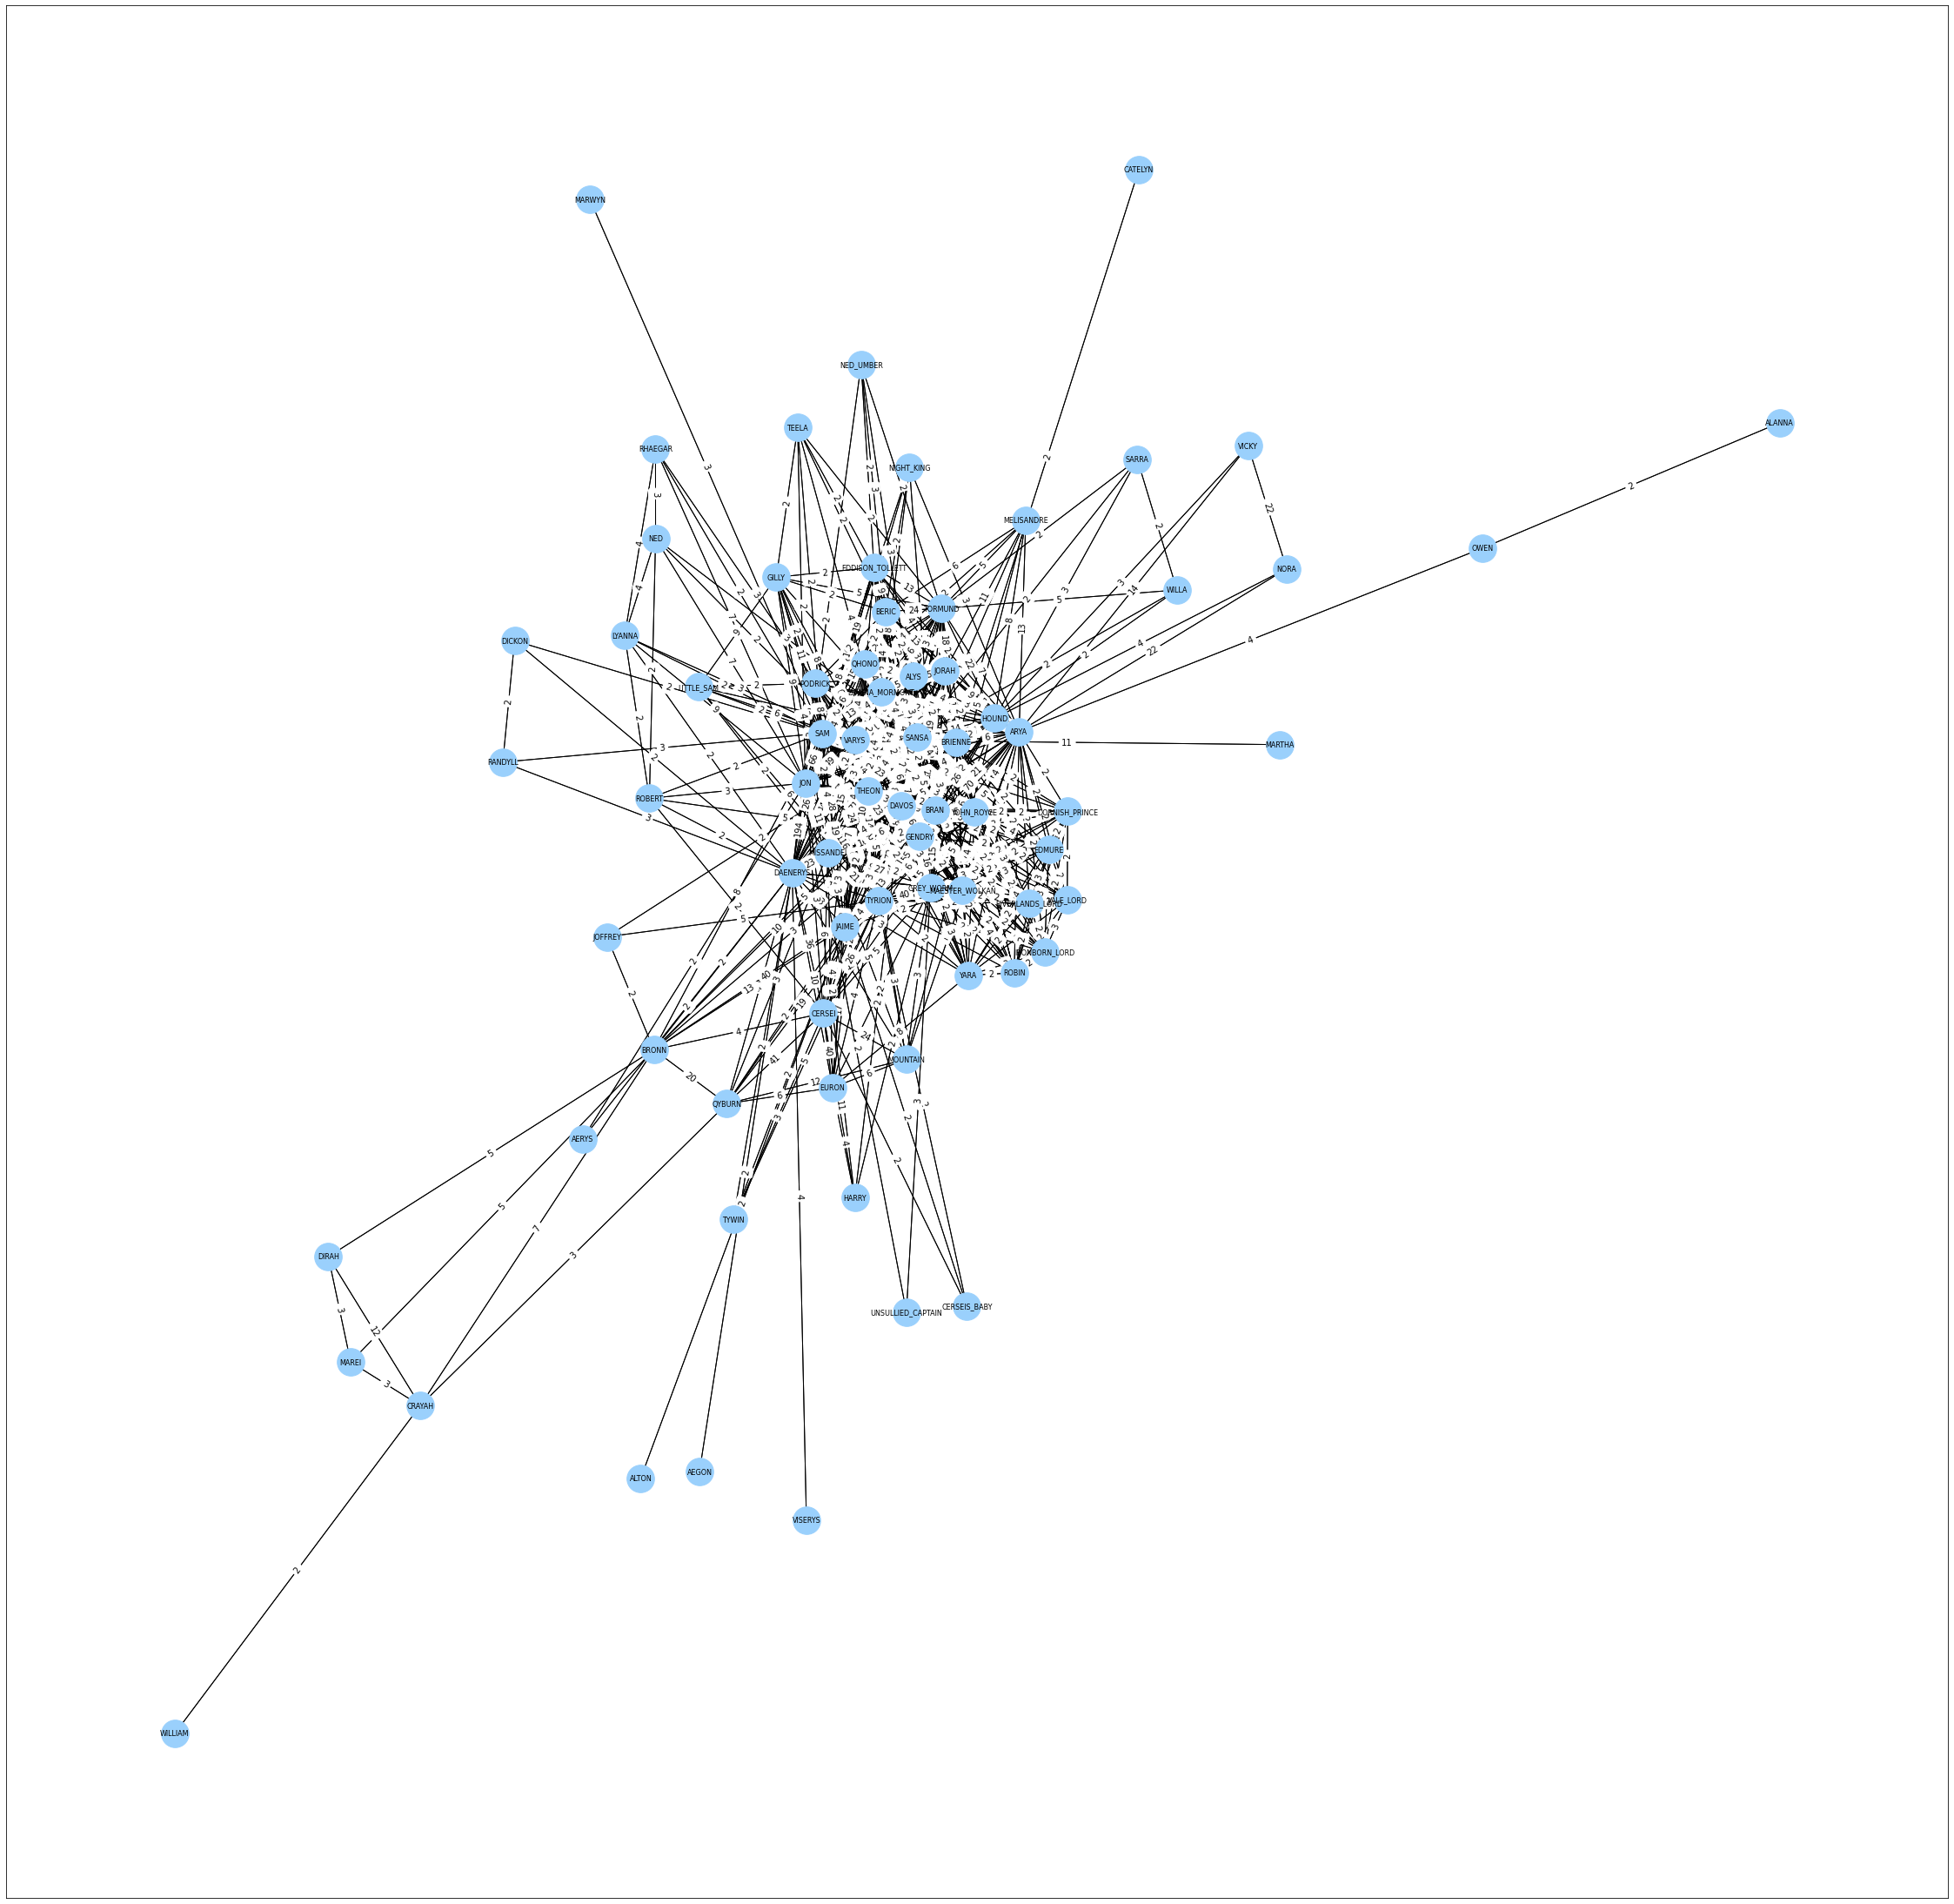

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(40,40))
pos = nx.spring_layout(G)

nx.draw_networkx(G,pos=pos, node_size = 1000, font_size=8, node_color="#9AD0FC")
nx.draw_networkx_edges(G, pos=pos)
edge_labels = nx.get_edge_attributes(G, 'Weight')
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)
plt.show()

In [ ]:
print("There are no self loops in the graph: ", len(list(nx.selfloop_edges(G))))
print("There are no isolates in the graph: ", len(list(nx.isolates(G))))

There are no self loops in the graph:  0
There are no isolates in the graph:  0


# **3. Calculate the following measures - betweenness centrality, page rank coefficient and local clustering coefficient**

## Degree Centrality

In [ ]:
deg_centrality = nx.degree_centrality(G)
print(sorted(deg_centrality.items(),key=lambda x:(x[1],x[0]),reverse=True))

[('SAM', 0.5915492957746479), ('TYRION', 0.5774647887323944), ('DAENERYS', 0.5774647887323944), ('SANSA', 0.5633802816901409), ('ARYA', 0.5492957746478874), ('GREY_WORM', 0.5352112676056339), ('DAVOS', 0.5211267605633803), ('JON', 0.5070422535211268), ('BRIENNE', 0.47887323943661975), ('JAIME', 0.4507042253521127), ('BRAN', 0.4507042253521127), ('VARYS', 0.4366197183098592), ('GENDRY', 0.4225352112676056), ('YOHN_ROYCE', 0.4084507042253521), ('TORMUND', 0.4084507042253521), ('BERIC', 0.3943661971830986), ('MISSANDEI', 0.35211267605633806), ('MAESTER_WOLKAN', 0.35211267605633806), ('JORAH', 0.35211267605633806), ('THEON', 0.3380281690140845), ('HOUND', 0.3380281690140845), ('QHONO', 0.323943661971831), ('LYANNA_MORMONT', 0.3098591549295775), ('ALYS', 0.3098591549295775), ('PODRICK', 0.29577464788732394), ('YARA', 0.28169014084507044), ('EDDISON_TOLLETT', 0.2535211267605634), ('CERSEI', 0.2535211267605634), ('VALE_LORD', 0.23943661971830987), ('ROBIN', 0.23943661971830987), ('RIVERLANDS_

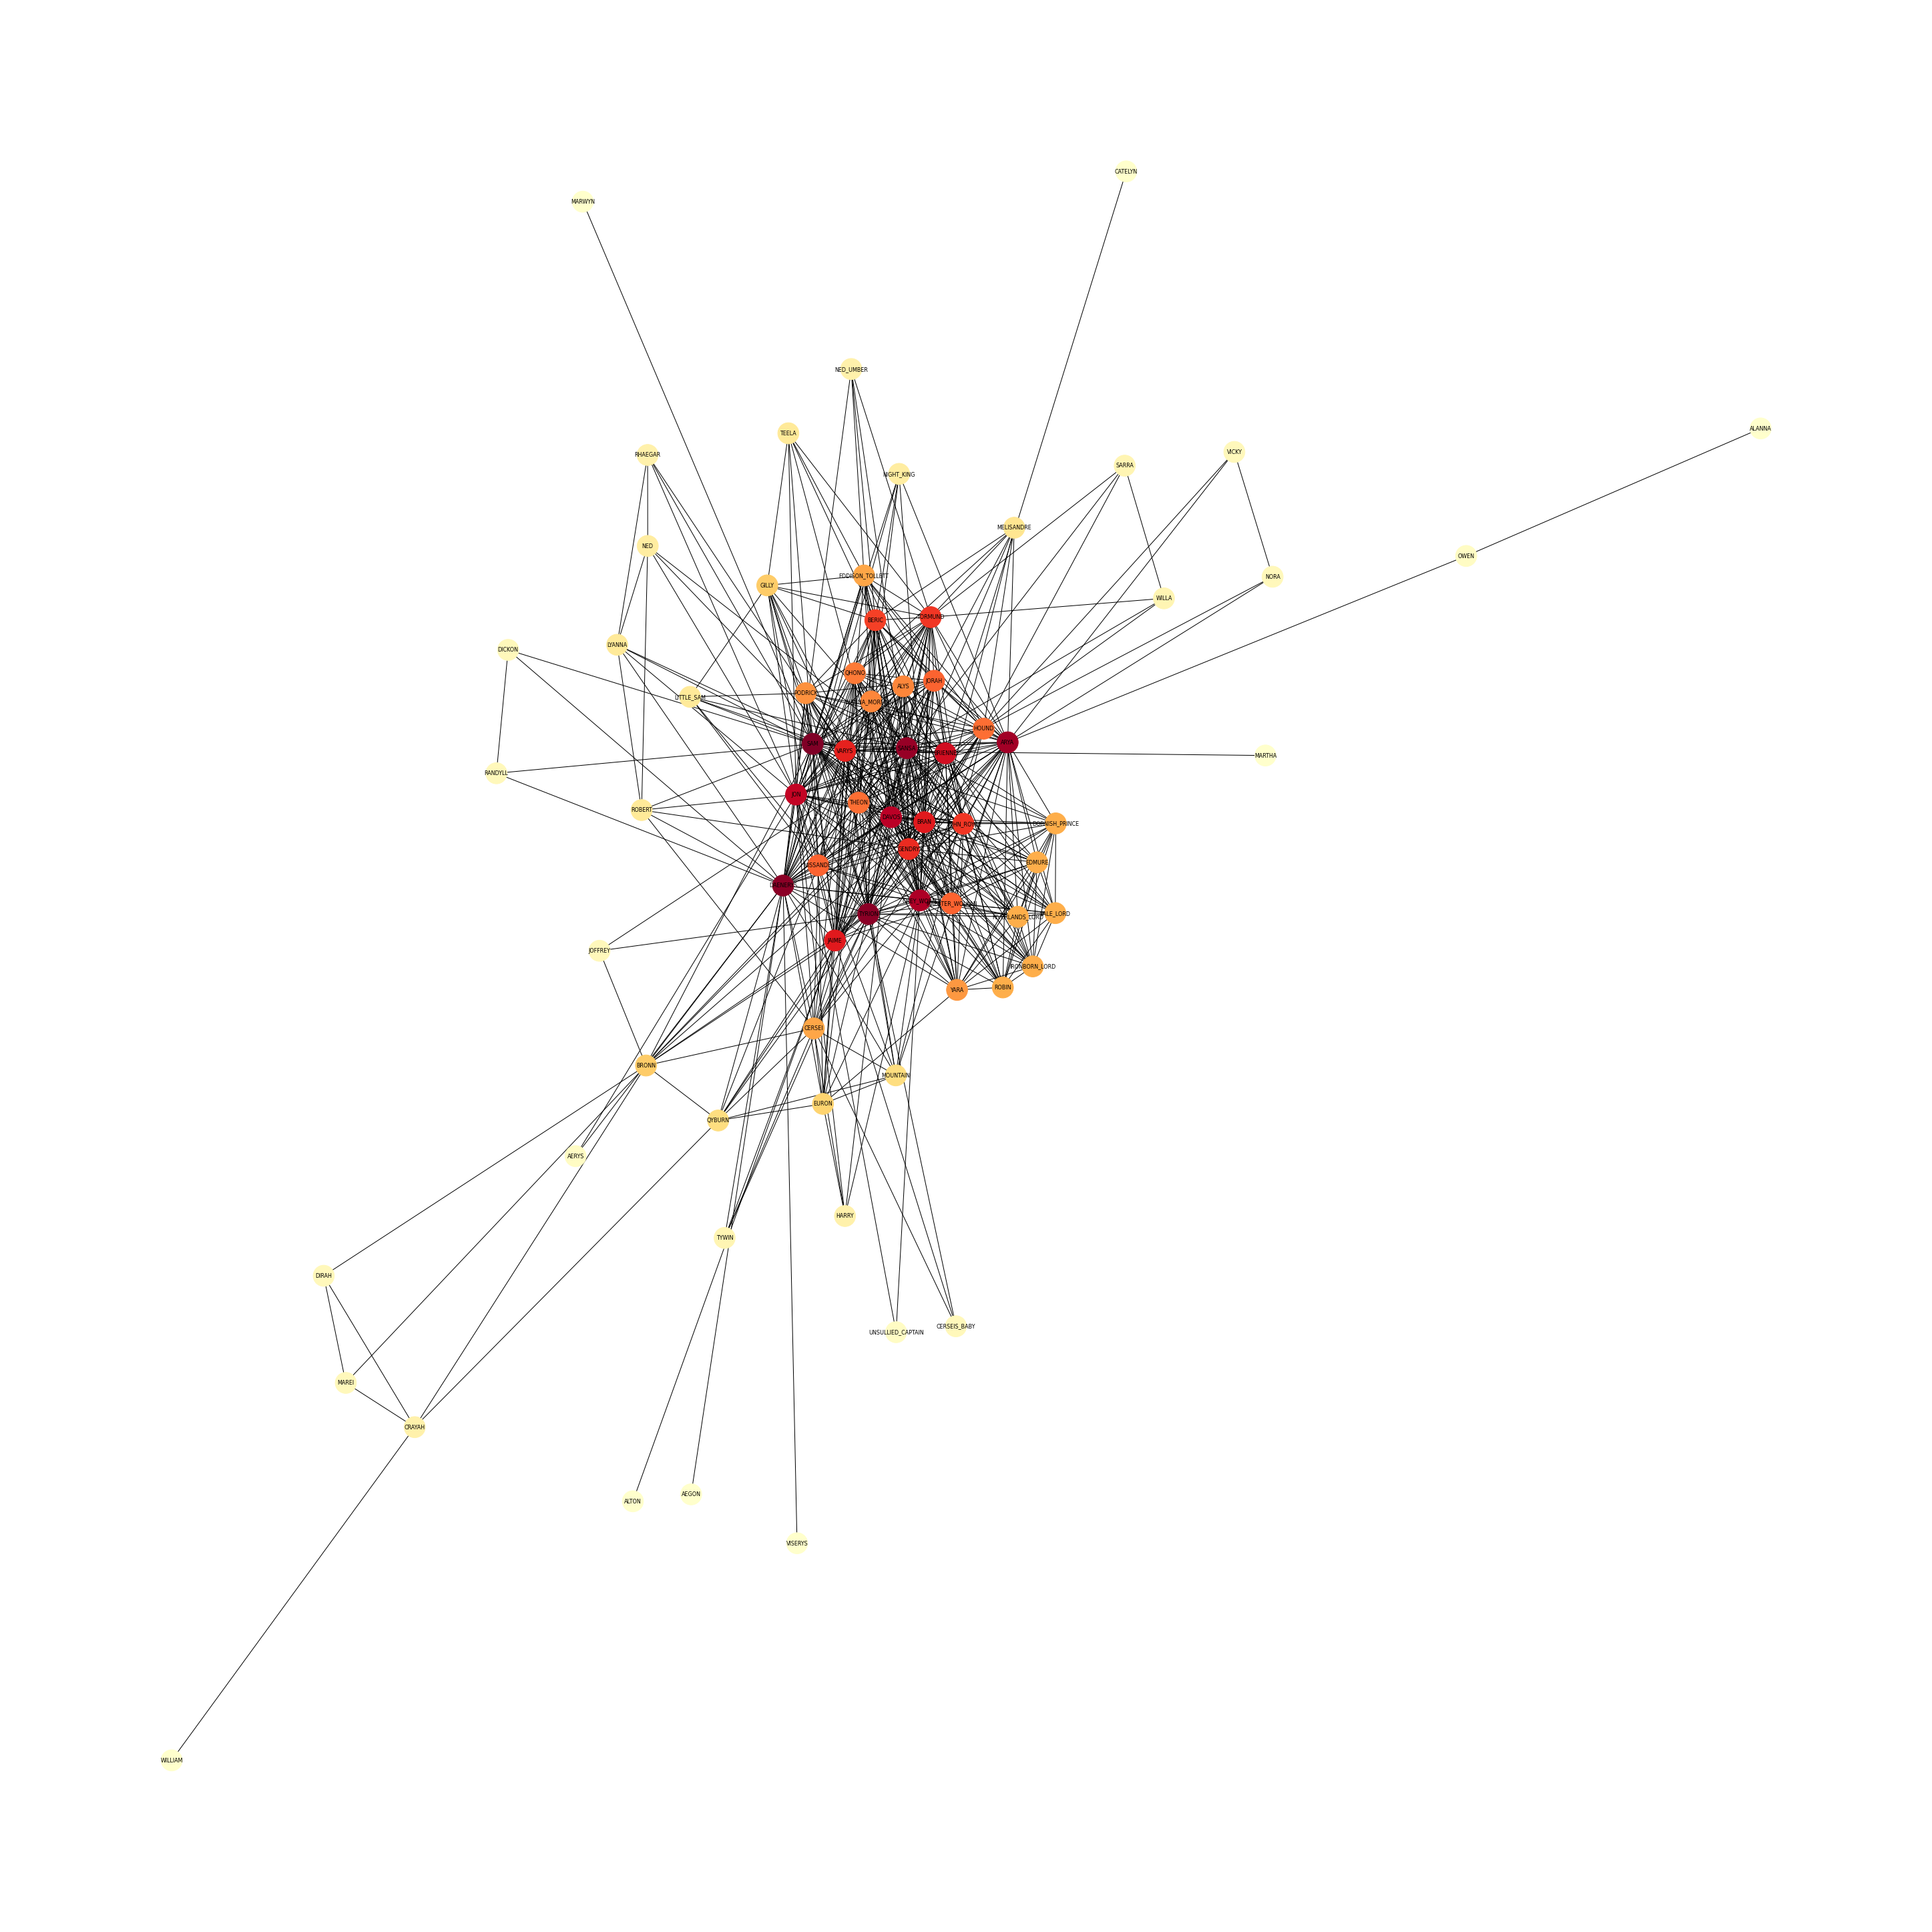

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(40,40))
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(deg_centrality.values()), node_size=1000, pos=pos, with_labels=True, font_size=8)

The most important characters in this season, as seen in the graph are the allied forces of Westoros that fought in the war and played pivotal roles in defeating the White Walkers. These characters plaayed important roles in the next half of the season in the war against Cersei.

## Closeness Measure

In [ ]:
close_centrality = nx.closeness_centrality(G)
print(sorted(close_centrality.items(),key=lambda x:(x[1],x[0]),reverse=True))

[('SAM', 0.696078431372549), ('TYRION', 0.6893203883495146), ('DAENERYS', 0.6893203883495146), ('DAVOS', 0.6635514018691588), ('SANSA', 0.6574074074074074), ('ARYA', 0.6574074074074074), ('GREY_WORM', 0.6454545454545455), ('BRIENNE', 0.6454545454545455), ('JON', 0.6339285714285714), ('JAIME', 0.6339285714285714), ('BRAN', 0.6339285714285714), ('VARYS', 0.6068376068376068), ('YOHN_ROYCE', 0.5966386554621849), ('TORMUND', 0.5966386554621849), ('GENDRY', 0.5966386554621849), ('BERIC', 0.5916666666666667), ('MISSANDEI', 0.5867768595041323), ('MAESTER_WOLKAN', 0.5772357723577236), ('JORAH', 0.5772357723577236), ('HOUND', 0.5772357723577236), ('THEON', 0.5725806451612904), ('QHONO', 0.568), ('LYANNA_MORMONT', 0.5634920634920635), ('ALYS', 0.5634920634920635), ('PODRICK', 0.5590551181102362), ('CERSEI', 0.5546875), ('YARA', 0.5461538461538461), ('EDDISON_TOLLETT', 0.5419847328244275), ('VALE_LORD', 0.5220588235294118), ('ROBIN', 0.5220588235294118), ('RIVERLANDS_LORD', 0.5220588235294118), ('

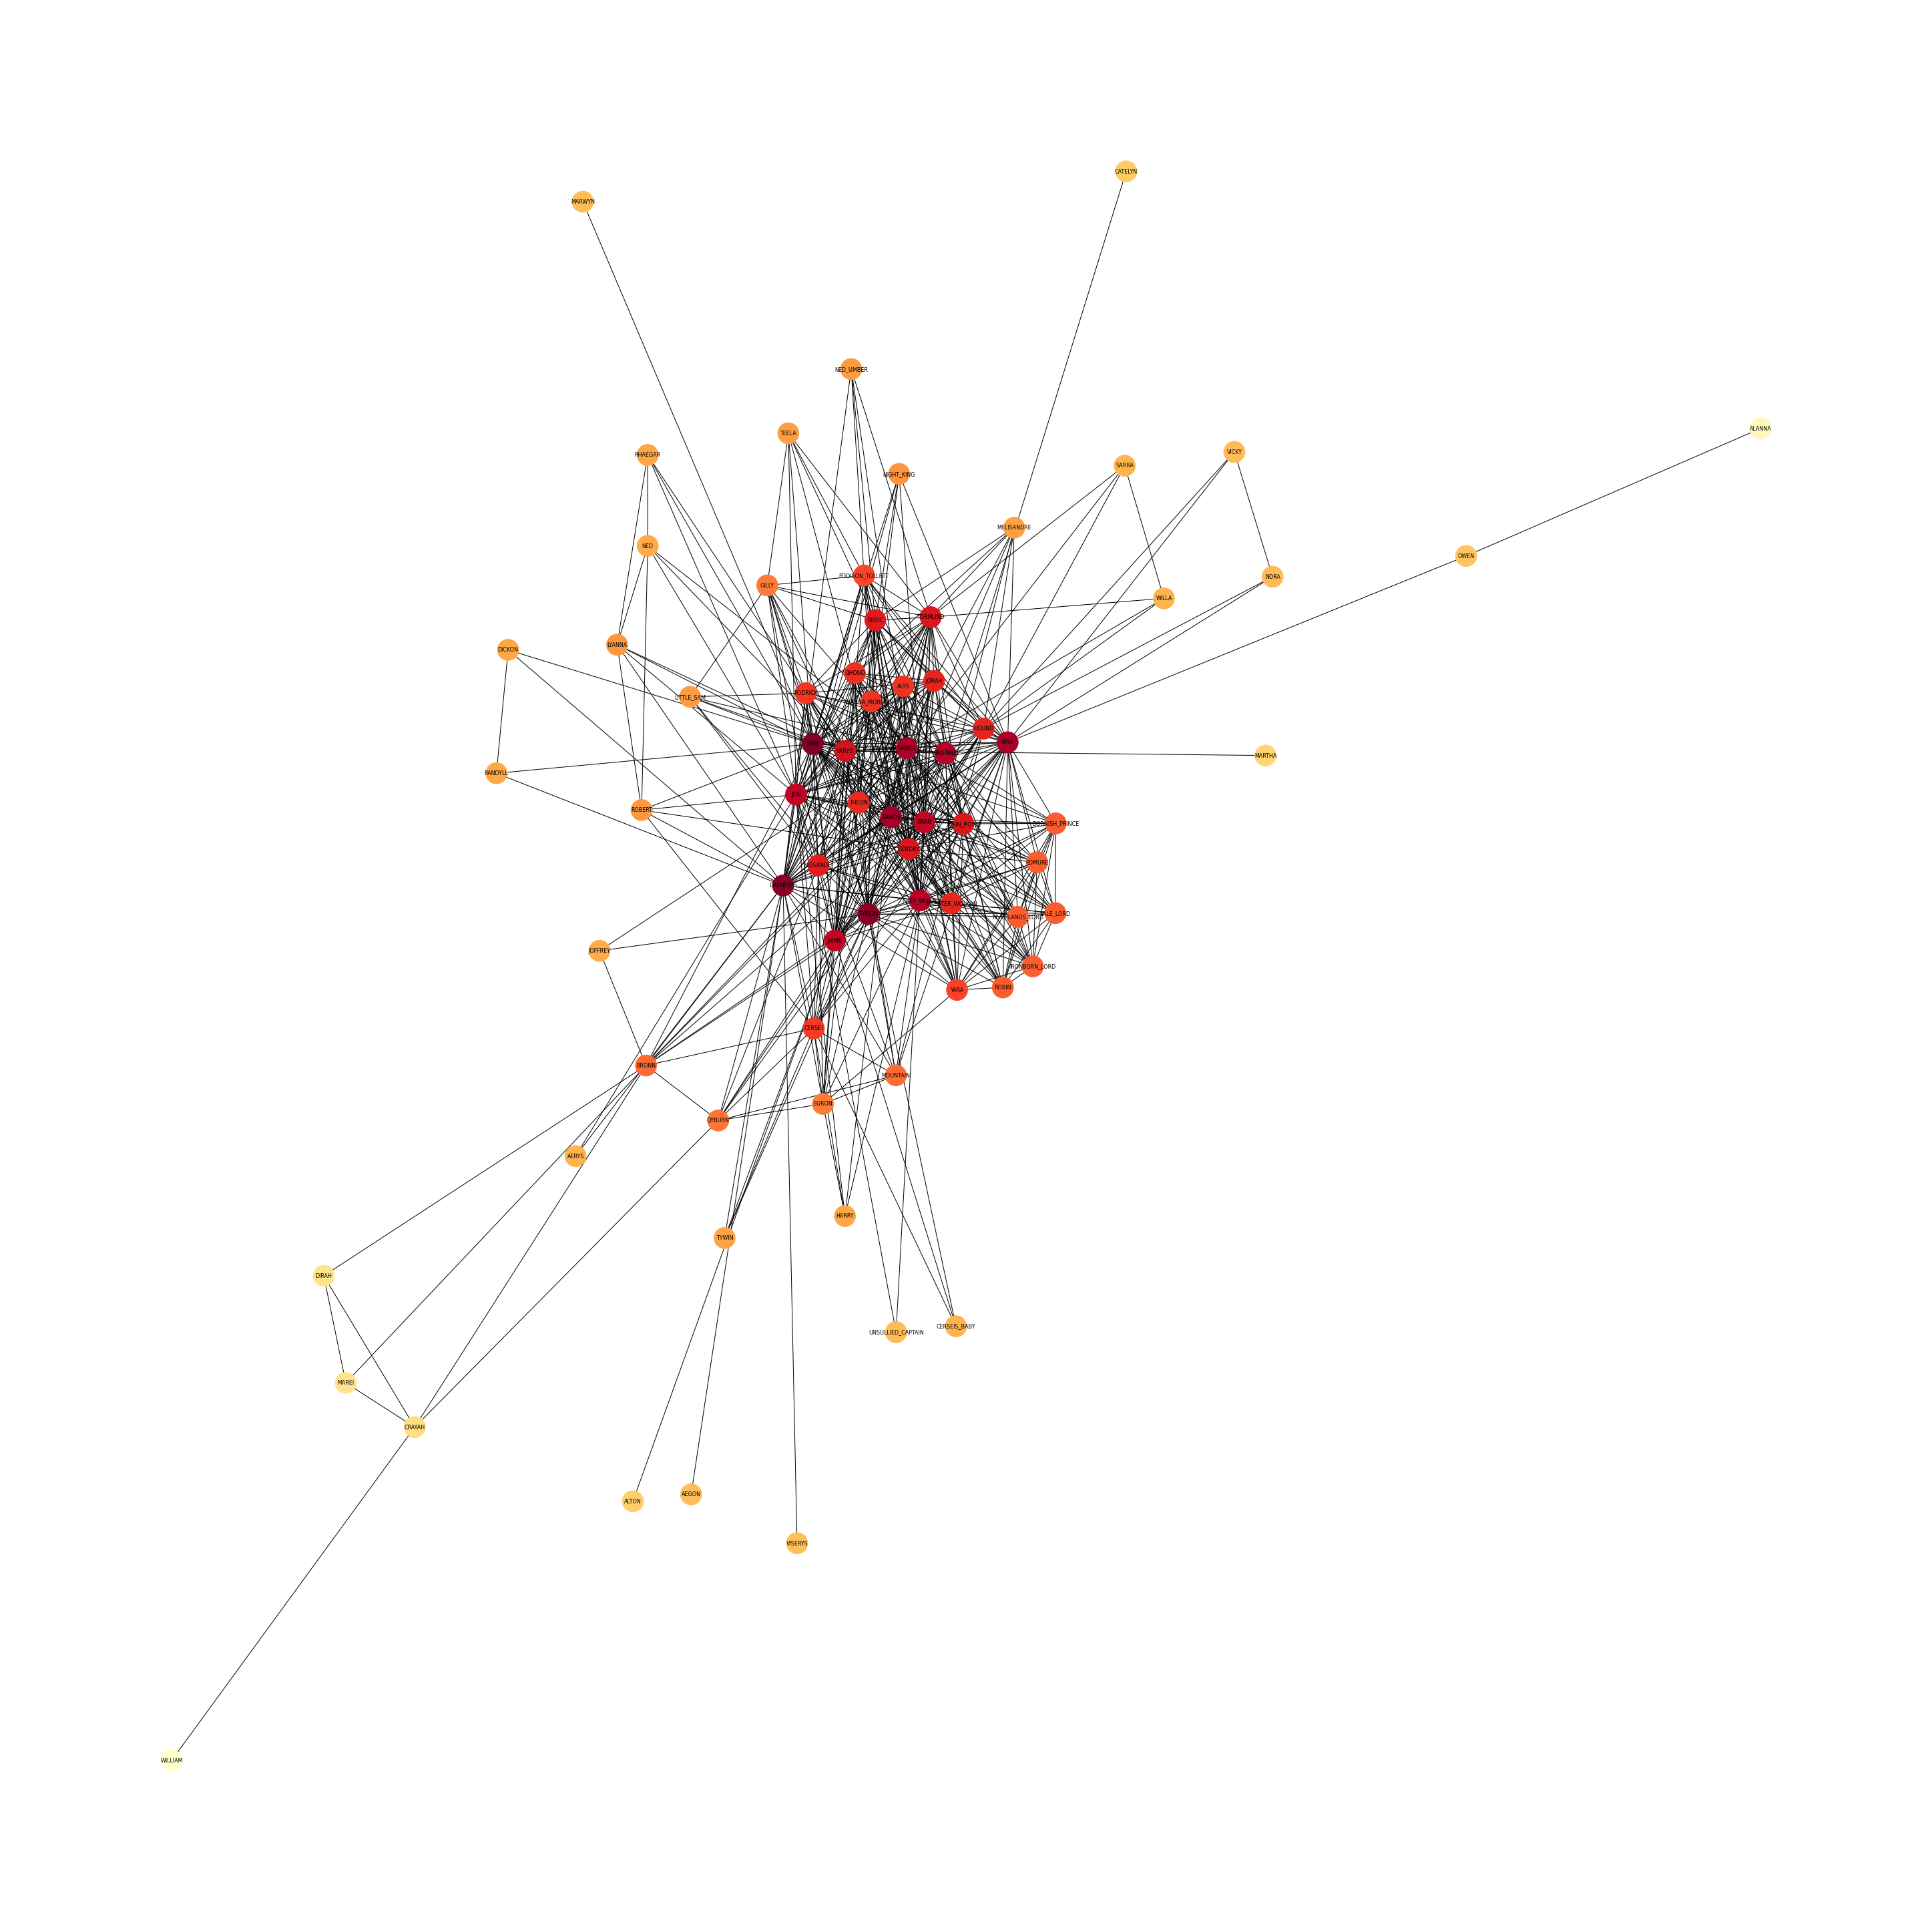

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(40,40))
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(close_centrality.values()), node_size=1000, pos=pos, with_labels=True, font_size=8)

## Betweenness Centrality

In [ ]:
bet_centrality = nx.betweenness_centrality(G, normalized = True, 
                                              endpoints = False)
print(sorted(bet_centrality.items(),key=lambda x:(x[1],x[0]),reverse=True))

[('DAENERYS', 0.14160700374953897), ('SAM', 0.10483754230700729), ('ARYA', 0.10471905916909657), ('BRONN', 0.08714311253091729), ('TYRION', 0.06674889414974863), ('SANSA', 0.0634478709183676), ('JON', 0.06027491871176086), ('JAIME', 0.05533424370188292), ('VARYS', 0.050389367482412496), ('BRIENNE', 0.04279016359458791), ('HOUND', 0.04071901980611063), ('GREY_WORM', 0.036235047027846884), ('DAVOS', 0.0336811076314986), ('CRAYAH', 0.029195512946962817), ('OWEN', 0.028169014084507043), ('QYBURN', 0.023982700133581), ('TORMUND', 0.023305595864716526), ('CERSEI', 0.019777512669567014), ('BRAN', 0.01656829616151206), ('BERIC', 0.011459114378396008), ('MISSANDEI', 0.009514504947381422), ('GENDRY', 0.008730190787483392), ('YOHN_ROYCE', 0.004436942264911561), ('EDDISON_TOLLETT', 0.003997290718600397), ('THEON', 0.003710326771635802), ('MAESTER_WOLKAN', 0.003202594312733409), ('EURON', 0.003042158479309688), ('PODRICK', 0.002831307997706848), ('JORAH', 0.0025589395587357856), ('YARA', 0.00249705

The closeness measures and betweeness centrality is in line with the degree centrality measures. 

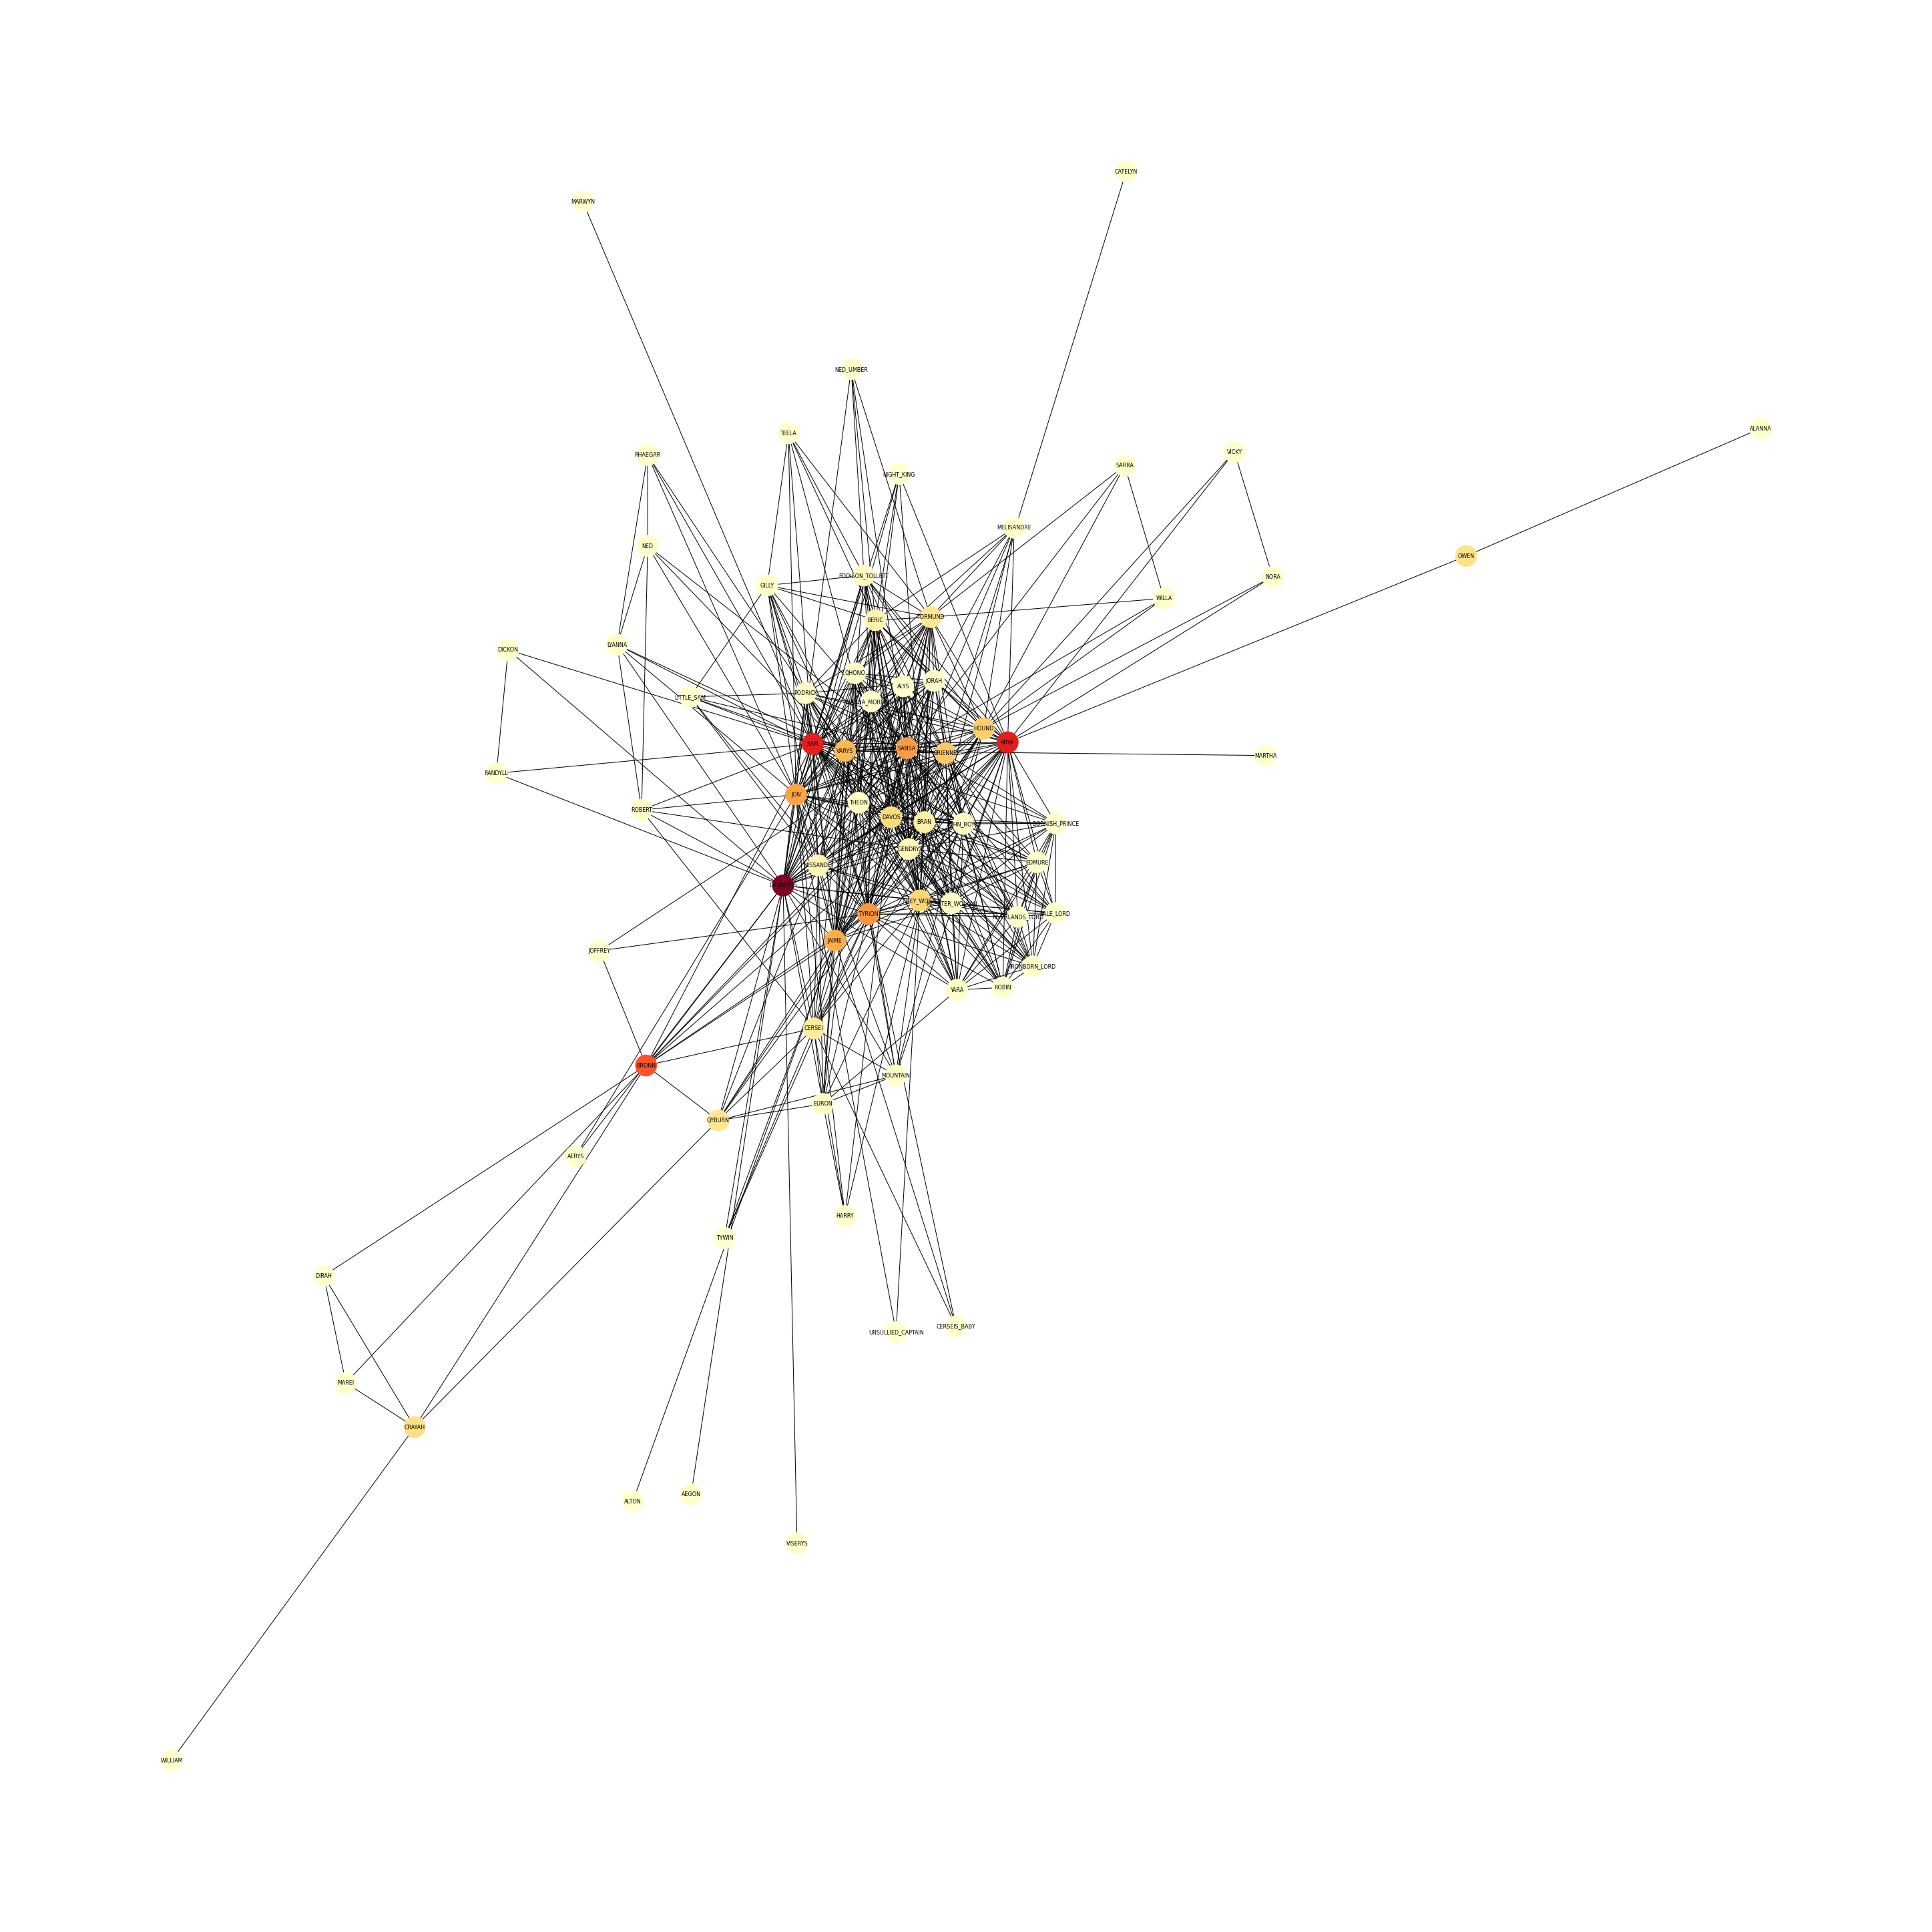

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(40,40))
nx.draw(G, cmap = plt.get_cmap('YlOrRd'), node_color = list(bet_centrality.values()), node_size=1000, pos=pos, with_labels=True, font_size=8)

## Page Rank Centrality

In [ ]:
pr = nx.pagerank(G, alpha = 0.8)
print(sorted(pr.items(),key=lambda x:(x[1],x[0]),reverse=True))

[('DAENERYS', 0.03868429765903393), ('SAM', 0.03517813509899522), ('ARYA', 0.032541917665341716), ('TYRION', 0.03190290141006807), ('SANSA', 0.031029464060877695), ('JON', 0.03012013679568978), ('GREY_WORM', 0.028716938180103214), ('DAVOS', 0.027356159147742486), ('JAIME', 0.027228998164812605), ('BRIENNE', 0.0267291011011454), ('VARYS', 0.02633292782062985), ('BRAN', 0.02354709358305593), ('TORMUND', 0.023064045883065317), ('GENDRY', 0.02204446686283231), ('HOUND', 0.02170809038813245), ('BERIC', 0.021595602387475134), ('YOHN_ROYCE', 0.021009029307788786), ('MISSANDEI', 0.019573851105679028), ('JORAH', 0.018829327604789003), ('MAESTER_WOLKAN', 0.018532920593979492), ('THEON', 0.018300798310019423), ('QHONO', 0.01740261996964882), ('CERSEI', 0.017283545524474097), ('LYANNA_MORMONT', 0.01669008172500964), ('BRONN', 0.01668645606589284), ('ALYS', 0.016620959258574607), ('PODRICK', 0.016504163419966716), ('YARA', 0.015407428861322842), ('EDDISON_TOLLETT', 0.014955444036041538), ('VALE_LOR

## Local Clustering Co-efficient

In [ ]:
print(sorted(nx.clustering(G).items(),key=lambda x:(x[1],x[0]),reverse=True))

[('WILLA', 1.0), ('VICKY', 1.0), ('VALE_LORD', 1.0), ('UNSULLIED_CAPTAIN', 1.0), ('TYWIN', 1.0), ('TEELA', 1.0), ('SARRA', 1.0), ('ROBIN', 1.0), ('RIVERLANDS_LORD', 1.0), ('RANDYLL', 1.0), ('NORA', 1.0), ('NIGHT_KING', 1.0), ('NED_UMBER', 1.0), ('MAREI', 1.0), ('LITTLE_SAM', 1.0), ('IRONBORN_LORD', 1.0), ('EDMURE', 1.0), ('DORNISH_PRINCE', 1.0), ('DIRAH', 1.0), ('DICKON', 1.0), ('CERSEIS_BABY', 1.0), ('AERYS', 1.0), ('MELISANDRE', 0.9642857142857143), ('ALYS', 0.9567099567099567), ('LYANNA_MORMONT', 0.9393939393939394), ('RHAEGAR', 0.9), ('QHONO', 0.8972332015810277), ('JORAH', 0.8533333333333334), ('YARA', 0.8526315789473684), ('MOUNTAIN', 0.8444444444444444), ('PODRICK', 0.8380952380952381), ('THEON', 0.8079710144927537), ('MAESTER_WOLKAN', 0.8066666666666666), ('EDDISON_TOLLETT', 0.7843137254901961), ('GILLY', 0.782051282051282), ('YOHN_ROYCE', 0.7733990147783252), ('LYANNA', 0.7619047619047619), ('HARRY', 0.7), ('GENDRY', 0.6988505747126437), ('BERIC', 0.6957671957671958), ('BRAN',

In [ ]:
# Local CLustering Co-efficient of Protagonists
protagonists = ['DAENERYS', 'SAM', 'ARYA', 'SANSA', 'JON']
local_clustering = nx.clustering(G)

for i in protagonists:
    print(i,local_clustering[i])

DAENERYS 0.4170731707317073
SAM 0.4645760743321719
ARYA 0.5263157894736842
SANSA 0.5076923076923077
JON 0.5031746031746032


# **4. Find communities using Spectral Clustering**

In [ ]:
# Class to perform spectral clustering for k clusters, given k

class SpectralClustering:
    
    def __init__(self, G):
        # Initialize the graph, nodes and the normalized Laplacian

        self.graph = G
        self.normalized_laplacian = nx.linalg.normalized_laplacian_matrix(G).toarray()
        self.nodes = G.nodes()

    def compute_eigenspace(self):
        # Compute the eigenvalues and the eigenvectors using Numpy and sort them in ascending order 

        eigenvalues, eigenvectors = np.linalg.eig(self.normalized_laplacian)

        sort_index = np.argsort(eigenvalues) # Returns the list of indices that would sort the array
        sorted_eigenvectors = eigenvectors[:, sort_index]

        return sorted_eigenvectors

    def fit(self, k):
        """
        Step 1: Extract the k eigen vectors and stack them vertically to form a matrix (i.e each vector is a column)
        Step 2: Every row of this matrix represents the features of the respective nodes of the graph
        Step 3: Perform K-Means clustering on this dataset to identify k clusters

        """
        eigenvectors = self.compute_eigenspace()
        k_eigenvectors = np.array(eigenvectors)[:,:k]
        dataset = pd.DataFrame(k_eigenvectors, index=self.nodes)

        # print(dataset)

        k_means_clusters = KMeans(n_clusters = k, random_state=42)
        self.clusters = k_means_clusters.fit(k_eigenvectors)
        
    def predict_labels(self):
        # Returns the labels 
        return self.clusters.labels_

    def assign_labels(self, labels):
        # Helper to assign the labels as node attributes
        for i,node in enumerate(self.graph.nodes()):
            self.graph.nodes[node]['label'] = labels[i]

    def plot_graph(self, n_clusters, title='Graph after Spectral Clustering'):
        # Plots the graph 

        labels = self.clusters.labels_
        self.assign_labels(labels)

        colour_list = ['blue','green','red','yellow','cyan', 'magenta','lightblue','grey']
        sampled_colours = dict(zip(set(labels),random.sample(colour_list, n_clusters)))

        legend_handles = []
        for label, color in sampled_colours.items():
            colour_handle = mpatches.Patch(color=color, label=label)
            legend_handles.append(colour_handle)

        colours = [sampled_colours[i] for i in labels]

        pos_fr = nx.fruchterman_reingold_layout(self.graph)
        plt.figure(figsize=(8,8))
        plt.title(title)
        plt.legend(handles=legend_handles)
        nx.draw(self.graph, pos=pos_fr, node_size=500, node_color=colours, with_labels=True)
        plt.show()

In [ ]:
import matplotlib.patches as mpatches
import matplotlib

[1 5 3 3 0 5 0 0 0 0 0 6 0 3 3 6 3 3 2 3 3 3 3 3 3 6 6 3 3 3 0 3 2 2 0 3 3
 3 3 5 3 0 5 5 3 2 0 5 3 6 3 4 3 3 0 0 3 1 0 0 3 6 0 3 3 3 4 3 3 3 2 1]


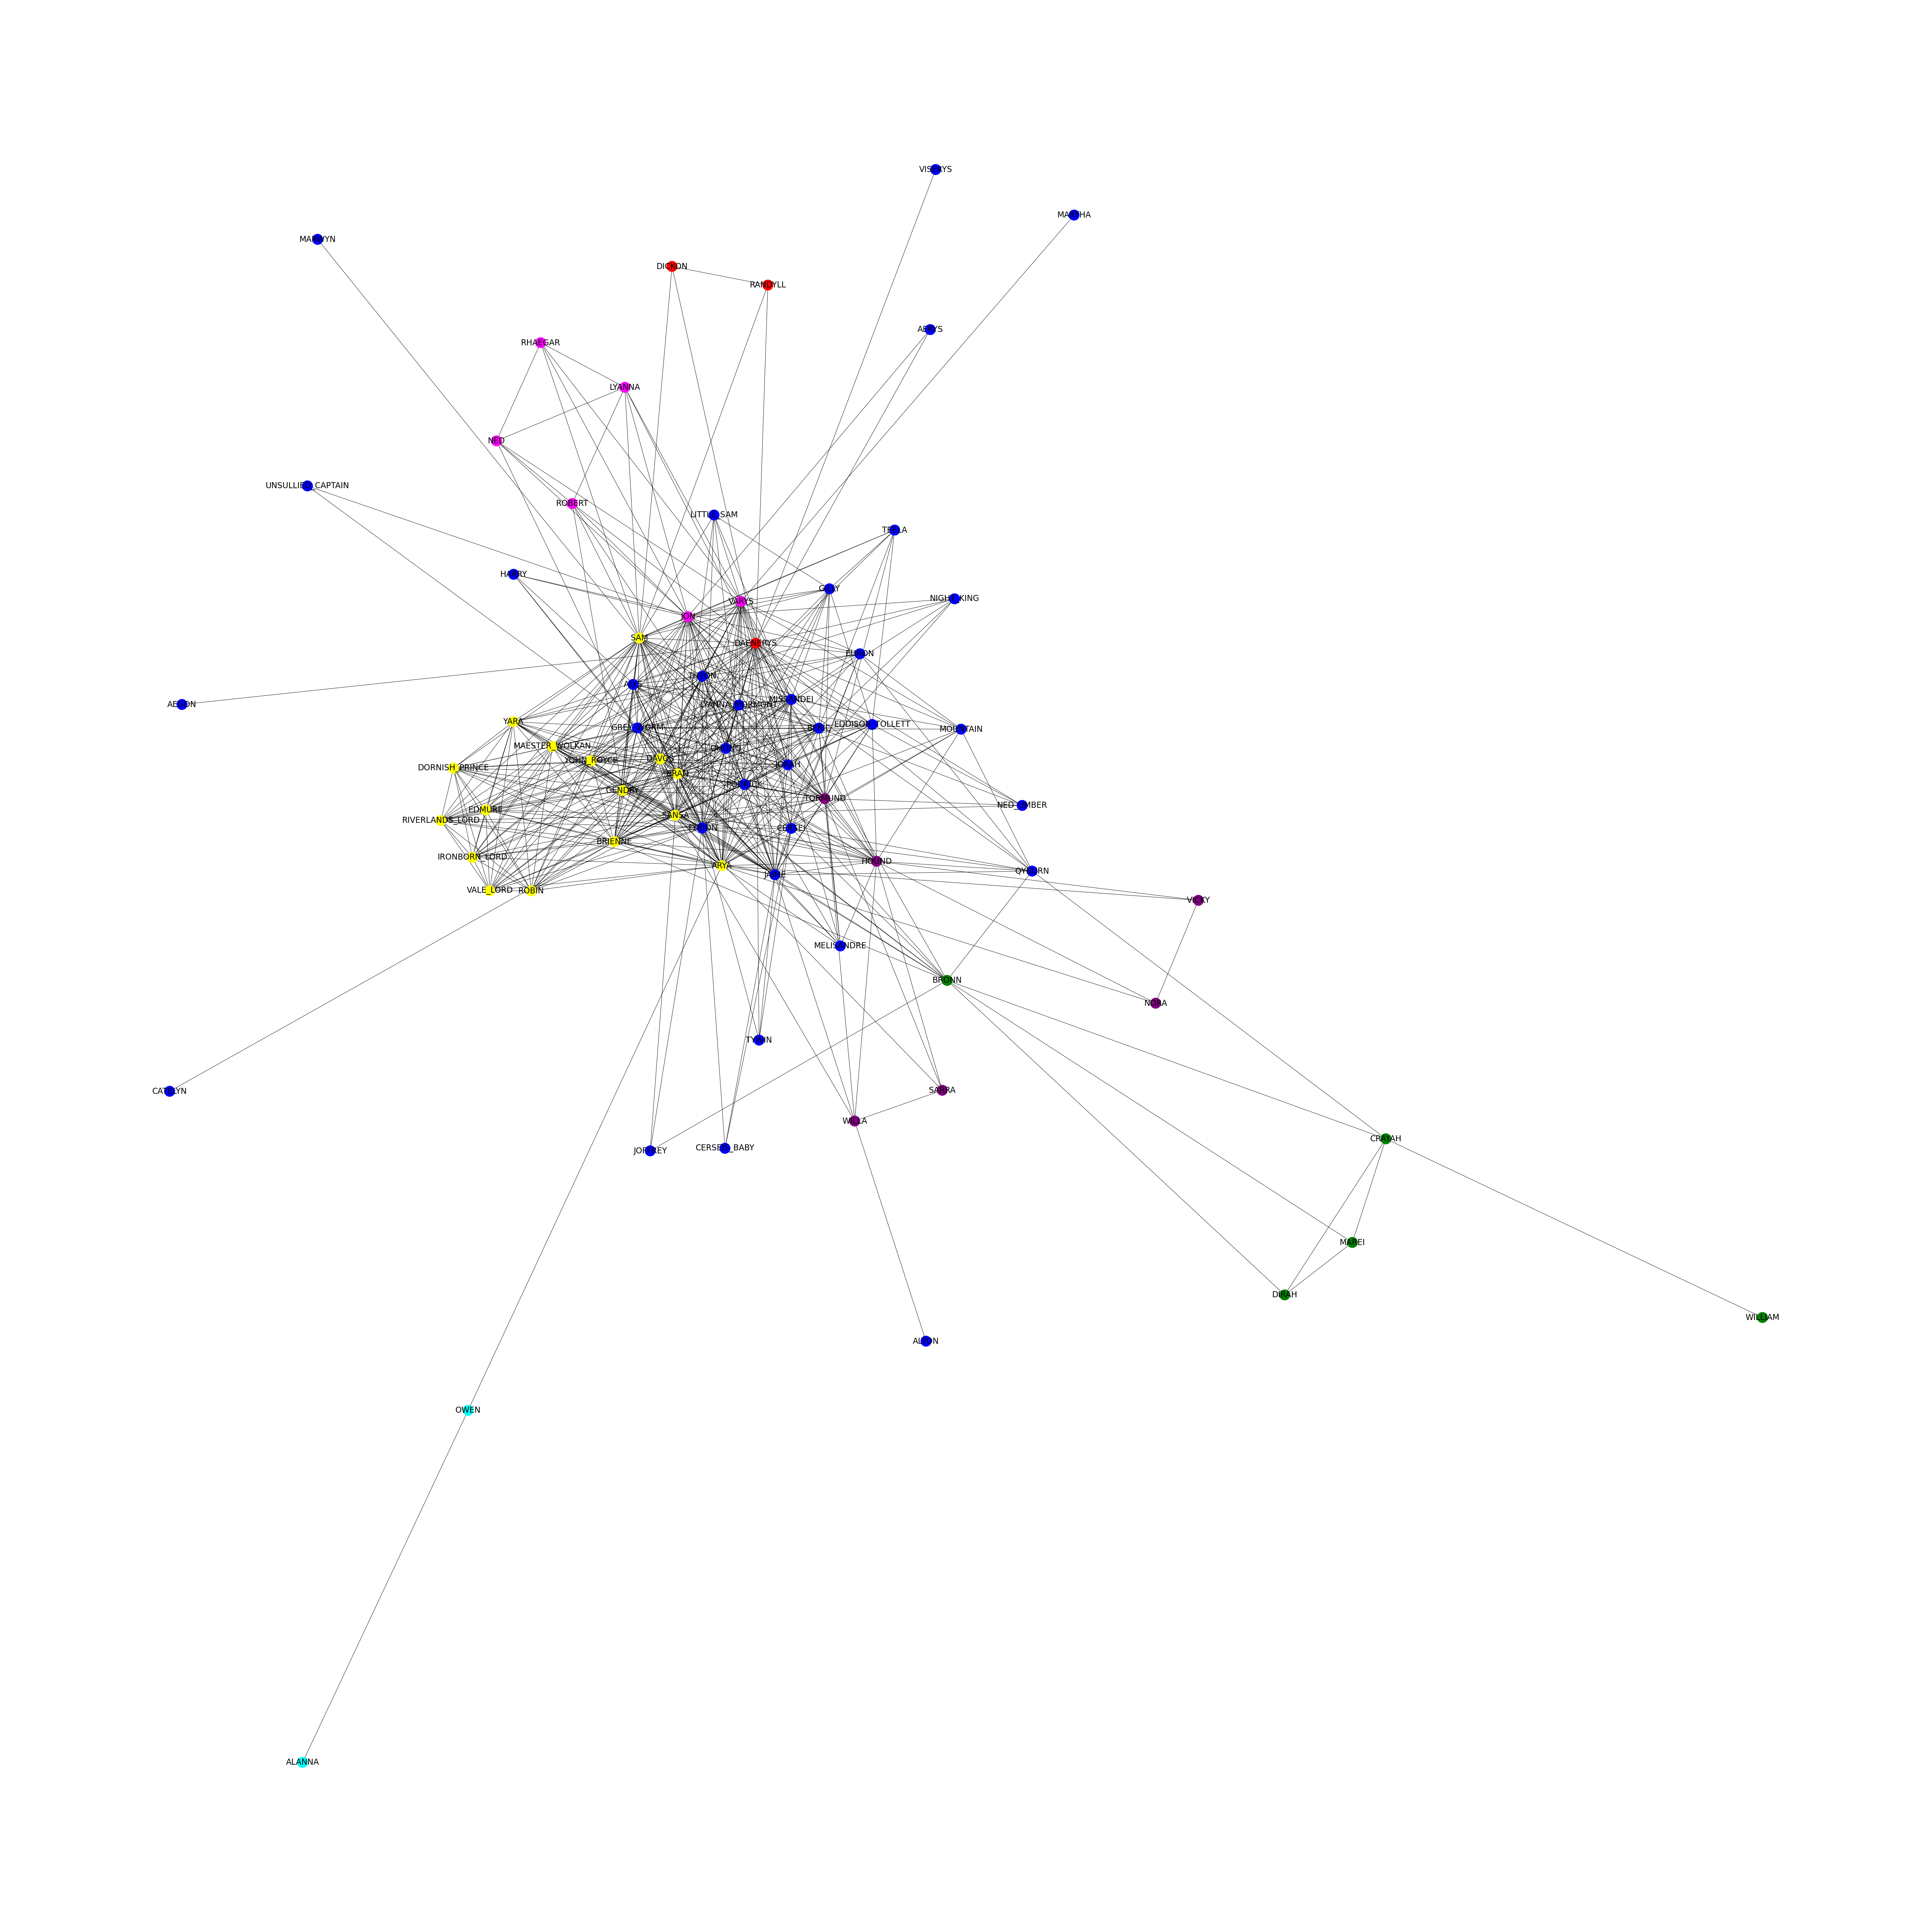

In [ ]:
# Performing Spectral Clustering on the graph
k = 7
SpecClust = SpectralClustering(G)
SpecClust.fit(k)
clustering_labels = SpecClust.predict_labels()
# print(labels)
print(clustering_labels)
l=['yellow','red','green','blue','cyan','magenta','purple','orange']
for i,node in enumerate(G.nodes()):
    G.nodes[node]['label'] = clustering_labels[i]
clrs=list(matplotlib.colors.cnames.values())
colour_map = ['']*len(clustering_labels)
for i, label in enumerate(clustering_labels):
    colour_map[i]=l[label]

# print(colour_map)
%matplotlib inline        
plt.figure(3, figsize=(80,80))
nx.draw(G, with_labels=True, node_color=colour_map, node_size = 1000, font_size = 24)
# SpecClust.plot_graph(k, title="Graph after Spectral Clustering")

We predicted that the clusters will be formed according to the houses each of the characters belong to to - The Lannisters, Starks and the Targaryens. However, on observing the graph, this does not seem to be the case.

In the graph, Sansa, Arya, Brann, belong to the Stark House and are in the same cluster

However, Mellisandra and Tyrion who helped defeat the White Walkers and Cersei belongs to the same cluster as NightKing and Cersei.

Similarily, Danerys and Jorah do not belong to the same cluster though Jorah has sworn loyalty to Danerys and dies trying to save her.
Ironically, he belongs to the same cluster as the NightKind

We realised that this is because of the fact that the entire Kingdom of Westeros comes together to fight the White Walkers and then Cersei. Hence, this distinction cannot be made.

# **5. Link Prediction using Traditional Methods**

In [ ]:
import numpy as np
import random
import networkx as nx
from IPython.display import Image
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [ ]:
n = G.number_of_nodes()
m = G.number_of_edges()
print("Number of nodes =", str(n))
print("Number of edges =", str(m))
print("Number of connected components =", str(nx.number_connected_components(G)))

Number of nodes = 72
Number of edges = 552
Number of connected components = 1


In [ ]:
# take a random sample of edges

proportion_edges = 0.25
edge_subset = random.sample(G.edges(), int(proportion_edges * G.number_of_edges()))

# remove some edges. the goal is to try and repredict these edges, and measure how close the prediction is to the original.

G_train = G.copy()
G_train.remove_edges_from(edge_subset)

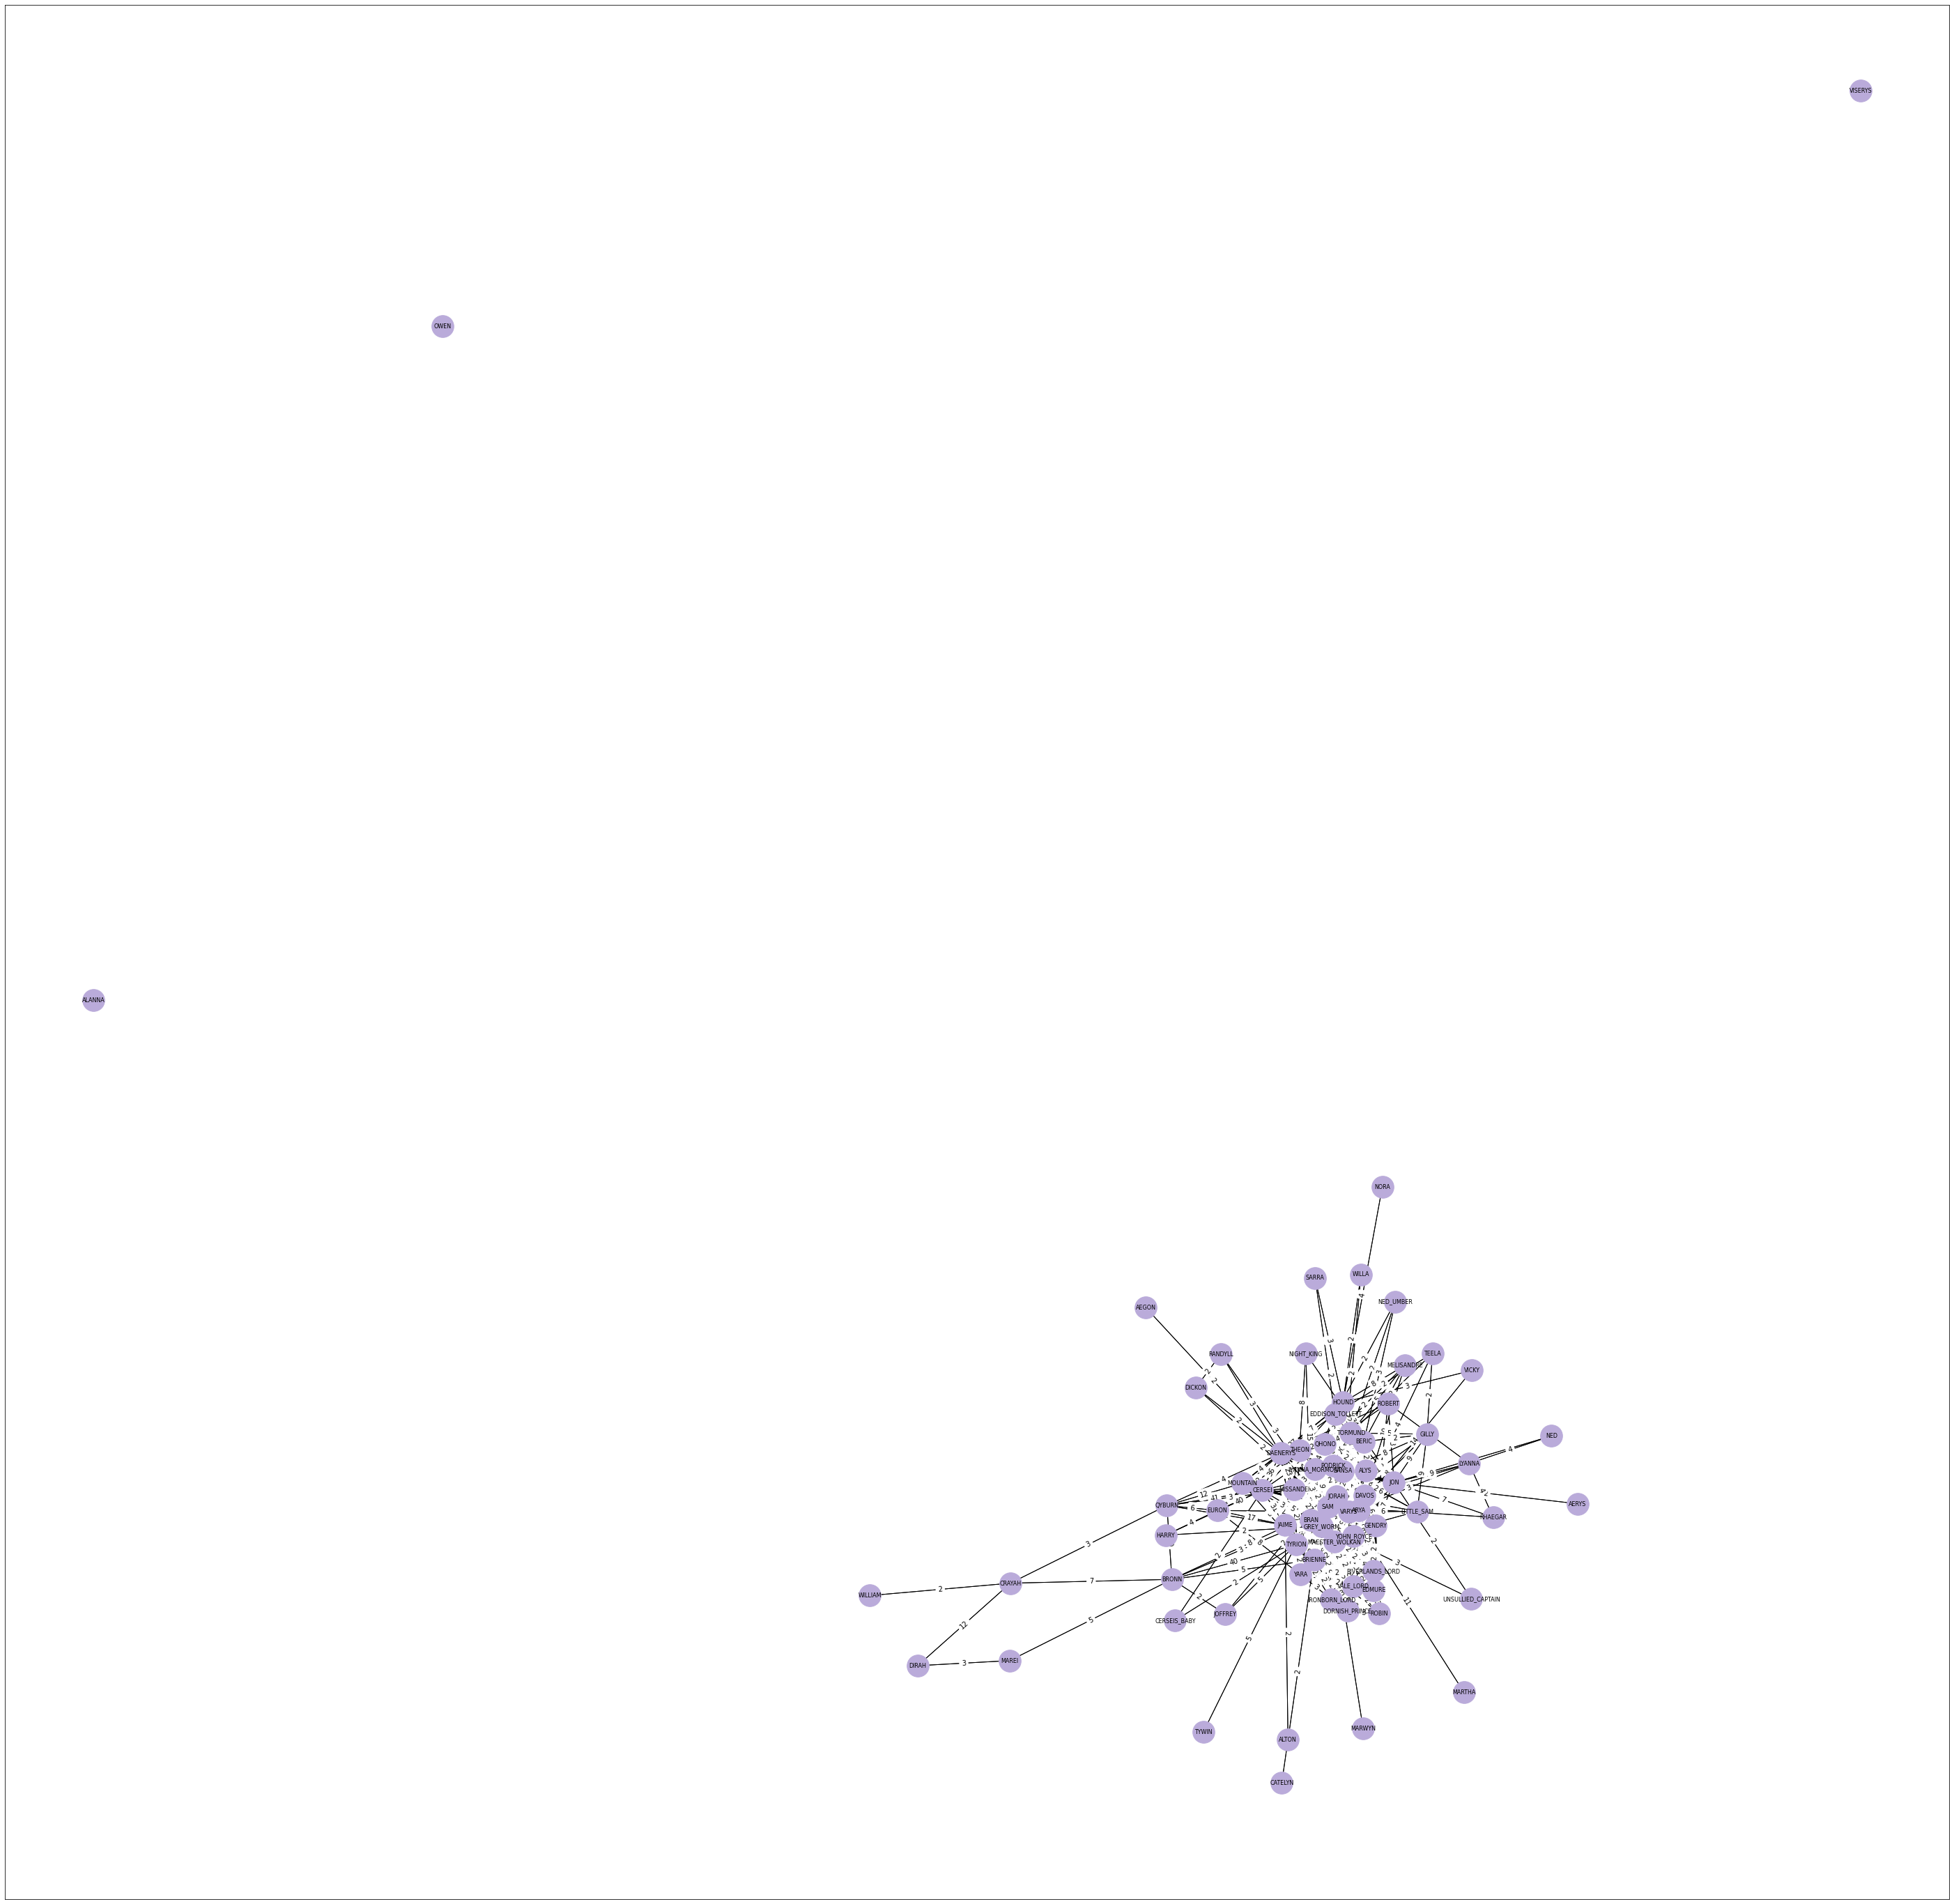

In [ ]:
%matplotlib inline
plt.figure(3, figsize=(50,50))
pos = nx.spring_layout(G_train)

nx.draw_networkx(G_train,pos=pos, node_size = 1000, font_size=8, node_color="#BAABDA")
nx.draw_networkx_edges(G_train, pos=pos)
edge_labels = nx.get_edge_attributes(G_train, 'Weight')
nx.draw_networkx_edge_labels(G_train, pos=pos, edge_labels=edge_labels)
plt.show()

In [ ]:
edge_subset_size = len(list(edge_subset))
print("Deleted edges =", str(edge_subset_size))
print("Remaining edges =", str(m - edge_subset_size))

# just printing the edge_subset.
print(edge_subset)

Deleted edges = 138
Remaining edges = 414
[('YARA', 'DORNISH_PRINCE'), ('SANSA', 'NED'), ('ARYA', 'GREY_WORM'), ('ARYA', 'BRAN'), ('OWEN', 'ALANNA'), ('ARYA', 'JORAH'), ('GREY_WORM', 'TORMUND'), ('TORMUND', 'SARRA'), ('DAENERYS', 'AERYS'), ('TYRION', 'DAVOS'), ('DAENERYS', 'TYWIN'), ('CERSEI', 'MOUNTAIN'), ('JON', 'QHONO'), ('JAIME', 'BRAN'), ('BRIENNE', 'SANSA'), ('BERIC', 'NIGHT_KING'), ('DAENERYS', 'SANSA'), ('DAVOS', 'GILLY'), ('TYRION', 'ROBIN'), ('BRIENNE', 'ARYA'), ('CERSEI', 'MISSANDEI'), ('SAM', 'GREY_WORM'), ('YARA', 'VALE_LORD'), ('SANSA', 'LYANNA_MORMONT'), ('CERSEI', 'BRONN'), ('TYRION', 'GREY_WORM'), ('TYRION', 'LYANNA_MORMONT'), ('ARYA', 'EDDISON_TOLLETT'), ('JON', 'TORMUND'), ('TYRION', 'SANSA'), ('SANSA', 'ROBIN'), ('JAIME', 'GENDRY'), ('ARYA', 'MELISANDRE'), ('EDDISON_TOLLETT', 'GILLY'), ('EDMURE', 'DORNISH_PRINCE'), ('NED', 'ROBERT'), ('MAESTER_WOLKAN', 'ROBIN'), ('HOUND', 'QYBURN'), ('VARYS', 'NED'), ('WILLA', 'SARRA'), ('CERSEI', 'TYWIN'), ('JON', 'BERIC'), ('DAENE

## Jaccard Co-efficient

In [ ]:
# calculating jaccard coefficient for all the node pairs in G.

prediction_jaccard = list(nx.jaccard_coefficient(G_train))
score_jaccard, label_jaccard = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_jaccard])

In [ ]:
# binary classification here. taking various thresholds for the jaccard coefficient.
# calculating fpr, tpr, and auc values for various thresholds of the jaccard coefficient.

fpr_jaccard, tpr_jaccard, thresholds_jaccard = roc_curve(label_jaccard, score_jaccard)
auc_jaccard = roc_auc_score(label_jaccard, score_jaccard)

## Adamic-Adar Co-efficent

In [ ]:
prediction_adamic = list(nx.adamic_adar_index(G_train))
score_adamic, label_adamic = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_adamic])

In [ ]:
fpr_adamic, tpr_adamic, thresholds_adamic = roc_curve(label_adamic, score_adamic)
auc_adamic = roc_auc_score(label_adamic, score_adamic)

## Preferential Attachement

In [ ]:
prediction_pref = list(nx.preferential_attachment(G_train))
score_pref, label_pref = zip(*[(s, (u,v) in edge_subset) for (u,v,s) in prediction_pref])

In [ ]:
fpr_pref, tpr_pref, thresholds_pref = roc_curve(label_pref, score_pref)
auc_pref = roc_auc_score(label_pref, score_pref)

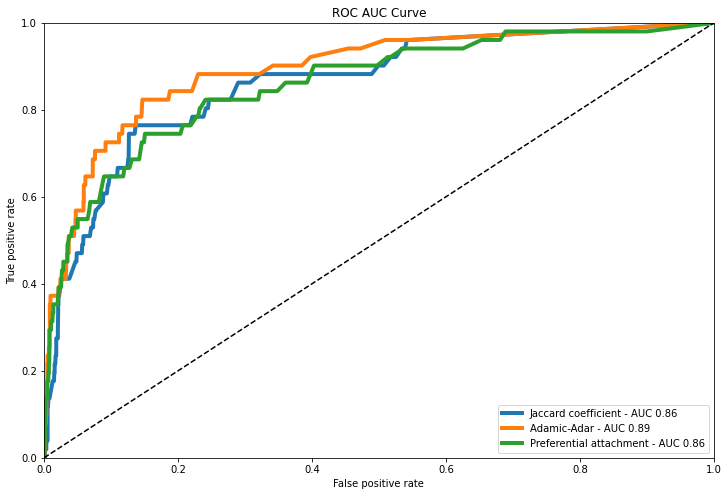

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(fpr_jaccard, tpr_jaccard, label='Jaccard coefficient - AUC %.2f' % auc_jaccard, linewidth=4)
plt.plot(fpr_adamic, tpr_adamic, label='Adamic-Adar - AUC %.2f' % auc_adamic, linewidth=4)
plt.plot(fpr_pref, tpr_pref, label='Preferential attachment - AUC %.2f' % auc_pref, linewidth=4)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("ROC AUC Curve")
plt.legend(loc='lower right')
plt.show()

however, in this particular case, it is clear from the auc, that adamic adar performs the best.

In [ ]:
# now, find the threshold value at which jaccard coefficient performs the best.

optimal_idx = np.argmax(tpr_adamic - fpr_adamic)
optimal_threshold = thresholds_adamic[optimal_idx]
print("Optimal threshold =", optimal_threshold)

# this is the threshold value above which a link will be classified as existant, and below which a link will be classified as non-existant.

Optimal threshold = 1.0259540879872961


The optimal threshold for Adamic Adar is 1.025

Obtained good accuracy of prediction with link promixity measures hence we are not using top-k approach

## Results of the three traditional graph methods (AUC metric):
1. Jaccard - 0.86
2. Adamic Adar - 0.89
3. Preferential Attachment - 0.86 

# **6. Link Prediction using GraphML**

1. GCN
2. GAT
3. GraphSAGE


In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

1.11.0+cu113


In [ ]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

     |████████████████████████████████| 7.9 MB 5.2 MB/s 
     |████████████████████████████████| 3.5 MB 3.7 MB/s 


In [ ]:
import torch as th

# Creating networkx graph 
nodes['s'] = pd.factorize(nodes['Id'])[0]
tag = dict(zip(nodes.Id, nodes.s))
print(tag)


edges["Source"] = edges['Source'].map(tag)
edges["Target"] = edges['Target'].map(tag)
edges = edges[['Source', 'Target', 'Weight']]
edges.head()

{'AEGON': 0, 'AERYS': 1, 'ALANNA': 2, 'ALTON': 3, 'ALYS': 4, 'ARYA': 5, 'BERIC': 6, 'BRAN': 7, 'BRIENNE': 8, 'BRONN': 9, 'CATELYN': 10, 'CERSEI': 11, 'CERSEIS_BABY': 12, 'CRAYAH': 13, 'DAENERYS': 14, 'DAVOS': 15, 'DICKON': 16, 'DIRAH': 17, 'DORNISH_PRINCE': 18, 'EDDISON_TOLLETT': 19, 'EDMURE': 20, 'EURON': 21, 'GENDRY': 22, 'GILLY': 23, 'GREY_WORM': 24, 'HARRY': 25, 'HOUND': 26, 'IRONBORN_LORD': 27, 'JAIME': 28, 'JOFFREY': 29, 'JON': 30, 'JORAH': 31, 'LITTLE_SAM': 32, 'LYANNA': 33, 'LYANNA_MORMONT': 34, 'MAREI': 35, 'MARTHA': 36, 'MARWYN': 37, 'MELISANDRE': 38, 'MISSANDEI': 39, 'MOUNTAIN': 40, 'NED': 41, 'NED_UMBER': 42, 'NIGHT_KING': 43, 'NORA': 44, 'OWEN': 45, 'PODRICK': 46, 'QHONO': 47, 'QYBURN': 48, 'RAMSAY': 49, 'RANDYLL': 50, 'RHAEGAR': 51, 'RIVERLANDS_LORD': 52, 'ROBERT': 53, 'ROBIN': 54, 'SAM': 55, 'SANSA': 56, 'SARRA': 57, 'TEELA': 58, 'THEON': 59, 'TORMUND': 60, 'TYRION': 61, 'TYWIN': 62, 'UNSULLIED_CAPTAIN': 63, 'VALE_LORD': 64, 'VARYS': 65, 'VICKY': 66, 'VISERYS': 67, 'WILL

Source  Target  Weight
0      14      30     194
1      14      61     122
2      28      61     122
3       8      28     121
4      30      61     116

In [ ]:
#converting networkx to pytorch geometric 
from torch_geometric.utils.convert import from_networkx

G_edge = nx.Graph()
# Iterating through the DataFrame to add edges
for _, edge in edges.iterrows():
    G_edge.add_edge(edge['Source'], edge['Target'], weight=edge['Weight'])

pyg = from_networkx(G_edge)
print(pyg)


Data(edge_index=[2, 1104], weight=[1104], num_nodes=72)


In [ ]:
# Adding empty array to add node embeddings
embeddings = np.array(list(dict(G_edge.degree()).values()))
#print(G_edge.degree())
print(embeddings)

[41 36 41 32 34 31 40 37 39 30 42 24 32 25 38 29 18 10 13 12 28 21 24 25
 10  3  3  6 22 18 29  8  5  3 25  5 13  1  7  7 22 20  6  5 23  3 17  7
  3  4  4  2  1  7 17 17  5  3 17 17  2  4 17  1  1  2  1  1  1  3  1  3]


In [ ]:
# normalizing degree  using StandardScaler
from sklearn.preprocessing import StandardScaler
import torch_geometric.transforms as T
from torch_geometric.transforms import RandomLinkSplit


scale = StandardScaler()
embeddings = scale.fit_transform(embeddings.reshape(-1,1))
pyg.x = torch.from_numpy(embeddings).type(torch.float32)
pyg

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = T.Compose([
    T.NormalizeFeatures(),
    T.ToDevice(device),
    T.RandomLinkSplit(num_val=0.05, num_test=0.1, is_undirected=True,
                      add_negative_train_samples=False),
])


In [ ]:
# Splitting edges into train, validate and test data
# each element representing the corresponding split.
dataset = pyg
dataset = dataset.to(device)
transform = RandomLinkSplit(is_undirected=True)
train_data, val_data, test_data = transform(dataset)

print(dataset.num_features)

1


# Model 1 - GCN


In [ ]:
from torch_geometric.nn.conv import GCNConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)

# hold the current state and will update the parameters based on the computed gradients.
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

# combining loss with sigmoid layer
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training the model

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    # Negative sampling - gives random negative edges given the edge index ; 
    #the weights of few edges that are randomly selected are updated at a time
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# Testing the model
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
from torch_geometric.utils import negative_sampling
best_val_auc = final_test_auc = 0
for epoch in range(1, 6):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test - The best Area under the Curve: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.6923, Val: 0.8631, Test: 0.8771
Epoch: 002, Loss: 0.6586, Val: 0.8582, Test: 0.8747
Epoch: 003, Loss: 0.6388, Val: 0.8314, Test: 0.8710
Epoch: 004, Loss: 0.6445, Val: 0.8076, Test: 0.8596
Epoch: 005, Loss: 0.6470, Val: 0.8139, Test: 0.8602
Final Test - The best Area under the Curve: 0.8602


In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)
print(z)

tensor([[-1.2828e-01,  1.9691e-01, -2.0303e-02,  ...,  1.5136e-01,
          4.5145e-02, -1.7712e-01],
        [-1.2163e-01,  1.8646e-01, -2.2744e-02,  ...,  1.4545e-01,
          4.5531e-02, -1.7681e-01],
        [-1.8281e-01,  2.8401e-01, -1.9552e-02,  ...,  2.1977e-01,
          4.4969e-02, -2.5809e-01],
        ...,
        [-4.2414e-04, -1.3458e-02, -1.7542e-02,  ..., -1.2238e-02,
          2.7949e-02, -2.0329e-02],
        [ 1.9592e-01, -4.2932e-01,  2.9448e-02,  ..., -3.2057e-01,
         -2.9870e-02,  5.0330e-01],
        [ 7.1079e-02, -1.5031e-01, -5.7078e-03,  ..., -1.1861e-01,
          1.5673e-02,  1.4617e-01]], grad_fn=<AddBackward0>)


# Model 2 - GAT

In [ ]:
from torch_geometric.nn.conv import GATConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training the model

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)

    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# Testing the model

@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
best_val_auc = final_test_auc = 0
for epoch in range(1, 6):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test - The best Area under the Curve: {final_test_auc:.4f}')

Epoch: 001, Loss: 0.7537, Val: 0.7868, Test: 0.8395
Epoch: 002, Loss: 0.6983, Val: 0.7788, Test: 0.8181
Epoch: 003, Loss: 0.6988, Val: 0.7802, Test: 0.8235
Epoch: 004, Loss: 0.6997, Val: 0.7812, Test: 0.8365
Epoch: 005, Loss: 0.6927, Val: 0.7927, Test: 0.8428
Final Test - The best Area under the Curve: 0.8428


In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

# Model 3 - GraphSAGE

In [ ]:
from torch_geometric.nn.conv import SAGEConv

class Net(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, out_channels)

    def encode(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

    def decode(self, z, edge_label_index):
        return (z[edge_label_index[0]] * z[edge_label_index[1]]).sum(dim=-1)

    def decode_all(self, z):
        prob_adj = z @ z.t()
        return (prob_adj > 0).nonzero(as_tuple=False).t()

In [ ]:
model = Net(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)
criterion = torch.nn.BCEWithLogitsLoss()

In [ ]:
# Training the model

def train():
    model.train()
    optimizer.zero_grad()
    z = model.encode(train_data.x, train_data.edge_index)
    
    neg_edge_index = negative_sampling(
        edge_index=train_data.edge_index, num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1), method='sparse')

    edge_label_index = torch.cat(
        [train_data.edge_label_index, neg_edge_index],
        dim=-1,
    )
    edge_label = torch.cat([
        train_data.edge_label,
        train_data.edge_label.new_zeros(neg_edge_index.size(1))
    ], dim=0)

    out = model.decode(z, edge_label_index).view(-1)
    loss = criterion(out, edge_label)
    loss.backward()
    optimizer.step()
    return loss

In [ ]:
# Testing the model
@torch.no_grad()
def test(data):
    model.eval()
    z = model.encode(data.x, data.edge_index)
    out = model.decode(z, data.edge_label_index).view(-1).sigmoid()
    return roc_auc_score(data.edge_label.cpu().numpy(), out.cpu().numpy())

In [ ]:
from torch_geometric.utils import negative_sampling
best_val_auc = final_test_auc = 0
for epoch in range(1, 6):
    loss = train()
    val_auc = test(val_data)
    test_auc = test(test_data)
    if val_auc > best_val_auc:
        best_val = val_auc
        final_test_auc = test_auc
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_auc:.4f}, '
          f'Test: {test_auc:.4f}')

print(f'Final Test - The best Area under the Curve: {final_test_auc:.4f}')

Epoch: 001, Loss: 9.0227, Val: 0.5289, Test: 0.5227
Epoch: 002, Loss: 27.5184, Val: 0.7529, Test: 0.7494
Epoch: 003, Loss: 6.2919, Val: 0.6180, Test: 0.6248
Epoch: 004, Loss: 6.1810, Val: 0.6248, Test: 0.5944
Epoch: 005, Loss: 13.4464, Val: 0.6722, Test: 0.6204
Final Test - The best Area under the Curve: 0.6204


In [ ]:
z = model.encode(test_data.x, test_data.edge_index)
final_edge_index = model.decode_all(z)

Results of Graph ML Models - 
1. GCN = 0.86
2. GAT = 0.84
3. GraphSAGE = 0.62

# **7. Perform a comparison between traditional and GraphML**

The perfomance of both the traditionaal methods and the Graph ML models is comparable, except for the case of GraphSAGE which seems to have a poor performance. 

The Graph ML models have good performance due to the node embeddings used. Hence, there is some structuraal information about the nodes that can be used for link prediction. 

Adamic Adar seems to have showed the best performance. It is a method of computing closeness based on shared neighbours. 
Since in the story, the graph is densely connected and most of the protganists have common neighbours with each other, this measure tunred out to be the best for the given graph.